In [1]:
import re
import warnings
import duckdb

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl

from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, List, Optional, Tuple
from scipy import integrate
from datetime import datetime, time, timedelta

from matplotlib import pyplot as plt
from matplotlib import font_manager as fm

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
FIGSIZE_ACM_SMALL = (3.33, 2.06)
FIGSIZE_ACM_LARGE = (7.00, 2.06)

flare = sns.color_palette("flare", 4)
colors = [flare[3], flare[1]]

sns.reset_defaults()
pd.options.display.float_format = '{:.5f}'.format
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Linux Libertine"],
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{libertine}",
    "mathtext.fontset": "custom",
    "mathtext.rm": "Linux Libertine",
    "mathtext.it": "Linux Libertine:italic",
    "mathtext.bf": "Linux Libertine:bold",
})

plt.rcParams.update({
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 10
})


Für `data_static` Pi 5 rausfiltern, für `data_dynamic` Nummer 2 (?) rausfiltern

In [5]:
def data_consumption(kind: str, melt: bool, raw: bool = False) -> pd.DataFrame:

    data = []
    with open(f"./data_{kind}/pi0/{kind}/consumption.log") as f:
        for line in f:
            data.append(re.findall(r"([-+]?\d*\.\d+|\d+)", line))
    df = pd.DataFrame(data=data, columns=["time", "V1", "A1", "V2", "A2", "V3", "A3", "V4", "A4", "V5", "A5"])
    
    df["time"] = df["time"].astype(np.float64)
    for i in range(1,6):
        df[f"W{i}"] = df[f"V{i}"].astype(np.float64) * df[f"A{i}"].astype(np.float64)

    if raw:
        return df

    if melt:
        df = pd.melt(df, id_vars="time", value_vars=[f"W{i}" for i in range(1, 6)], var_name="pi", value_name="W")
        label_map = {"W1": "1", "W2": "2", "W3": "3", "W4": "4", "W5": "5"}
        df["pi"] = df["pi"].replace(label_map)
    
    else:
        df["W"] = df["W1"] + df["W2"] + df["W3"] + df["W4"] + df["W5"]
        df = df.drop(["V1", "A1", "V2", "A2", "V3", "A3", "V4", "A4", "V5", "A5", "W1", "W2", "W3", "W4", "W5"], axis=1)
        
        df["time"] = pd.to_datetime(df["time"], unit="s")
        df = df.set_index("time")
        df = df.resample("1S").mean()
        df = df.reset_index(False)
        
        df["time"] = pd.to_numeric(df["time"])/10**9
        df["time"] = df["time"].astype(int)
        df["time"] = df["time"] - df["time"].min()
        
        df = df.dropna(subset=["W"])
        df["W"] = df["W"].interpolate()

    return df

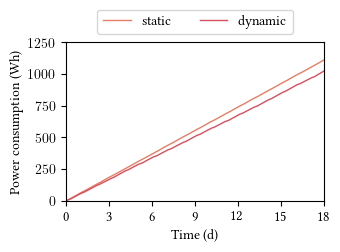

In [101]:
data_dynamic = data_consumption("dynamic", False)
data_dynamic["J"] = integrate.cumulative_trapezoid(y=data_dynamic["W"], x=data_dynamic["time"], initial=0)
data_dynamic["Wh"] = data_dynamic["J"]/3_600

data_static = data_consumption("static", False)
data_static["J"] = integrate.cumulative_trapezoid(y=data_static["W"], x=data_static["time"], initial=0)
data_static["Wh"] = data_static["J"]/3_600

def plot_consumption_cluster_total(data_static: pd.DataFrame, data_dynamic: pd.DataFrame, colors: list) -> None:

    fig, ax = plt.subplots(figsize=FIGSIZE_ACM_SMALL)

    sns.lineplot(x="time", y="Wh", data=data_static, ax=ax, label="static", color=colors[0], linewidth=1)
    sns.lineplot(x="time", y="Wh", data=data_dynamic, ax=ax, label="dynamic", color=colors[1], linewidth=1)

    #plt.fill_between(
    #    x=data_static["time"], 
    #    y1=data_static["Wh"], 
    #    y2=data_dynamic["Wh"][:len(data_static["Wh"])], 
    #    color="green", alpha=0.25
    #)
    
    xlim = 86_400 * 3
    ax.set_xlabel("Time (d)")
    ax.set_xlim(0, xlim)
    ax.set_xticks(
        ticks=range(0, xlim+1, xlim//6),
        labels=range(0, 18+1, 3)
    )

    ylim = 1250
    ax.set_ylabel("Power consumption (Wh)")
    ax.set_ylim(0, ylim)

    ax.grid(False)

    ax.legend(
        loc="upper center",
        ncols=2,
        bbox_to_anchor=(0.5, 1.25),
        reverse = False,
        frameon = True,
        fancybox = True,
    )

    plt.show()
    #fig.savefig("../2025-paper-HaveYouTriedTurningItOff/graphs/consumption_cluster_total.pdf", bbox_inches="tight")
    plt.close()

plot_consumption_cluster_total(data_static, data_dynamic, colors=colors)

In [334]:
dfs = data_consumption(kind="static", melt=False, raw=True)
dfs["nodes_active"] = (dfs["W1"] != 0).astype(np.int64) + (dfs["W2"] != 0) + (dfs["W3"] != 0) + (dfs["W4"] != 0) + (dfs["W5"] != 0)
dfs["nodes_active_scaled"] = dfs["nodes_active"] * 5
dfs["W"] = dfs["W1"] + dfs["W2"] + dfs["W3"] + dfs["W4"] + dfs["W5"]
dfs["time"] = dfs["time"]-dfs["time"].min()

dfd = data_consumption(kind="dynamic", melt=False, raw=True)
dfd["nodes_active"] = (dfd["W1"] != 0).astype(np.int64) + (dfd["W2"] != 0) + (dfd["W3"] != 0) + (dfd["W4"] != 0) + (dfd["W5"] != 0)
dfd["nodes_active_scaled"] = dfd["nodes_active"] * 5
dfd["W"] = dfd["W1"] + dfd["W2"] + dfd["W3"] + dfd["W4"] + dfd["W5"]
dfd["time"] = dfd["time"]-dfd["time"].min()

def plot_power_draw_24h(df: pd.DataFrame, colors: list, filename: str) -> None:

    fig, ax1 = plt.subplots(figsize=FIGSIZE_ACM_SMALL)
    ax2 = ax1.twinx()

    sns.lineplot(x="time", y="W", data=df, ax=ax1, linestyle="-", color=colors[0], label="power", linewidth=1)
    sns.lineplot(x="time", y="nodes_active_scaled", data=df, ax=ax1, linestyle="-", color=colors[1], label="nodes", linewidth=1)
    
    ax1.set_ylabel("Power (W)")
    ax1.set_ylim(0, 25)

    ax2.set_ylabel("Active nodes")
    ax2.set_ylim(0, 5)

    xlim = 86_400 // 6
    ax1.set_xlabel("Time (h)")
    ax1.set_xlim(xlim, xlim*2)
    ax1.set_xticks(
        ticks=range(xlim, 2*xlim+1, xlim//6),
        labels=range(0, 24+1, 4)
    )
    
    ax1.legend(
        loc="upper center",
        ncols=2,
        bbox_to_anchor=(0.5, 1.25),
        reverse = False,
        frameon = True,
        fancybox = True,
    )
    
    fig.savefig(filename, bbox_inches="tight")
    plt.close()

plot_power_draw_24h(dfs, colors, "power_draw_24h_static.pdf")
plot_power_draw_24h(dfd, colors, "power_draw_24h_dynamic.pdf")

In [204]:
def data_invocations(kind: str) -> pd.DataFrame:

    def start_stop(line: str) -> (str, str):
        line = line.strip()
        contents = line.split(", ")
        contents = contents[1:]
        start, stop = contents[0].split(".")[0], contents[1].split(".")[0]
        return start, stop
    
    base_date = datetime.strptime("1970-01-01", "%Y-%m-%d").date()
    data = []
    for i in range(4):
        start_date = base_date
        last_start = None
        with open(f"./data_{kind}/pi{i}/{kind}/fn_invocations.log") as f:
            counter = 0
            for line in f:
                start, stop = start_stop(line)
                if last_start and int(last_start[:2]) == 23 and int(start[:2]) == 0:
                    start_date += timedelta(days=1)
                date_stop = start_date
                if int(start[:2]) > int(stop[:2]):
                    date_stop += timedelta(days=1)
                t_start = datetime.strptime(f"{start_date} {start}", "%Y-%m-%d %H:%M:%S")
                t_stop = datetime.strptime(f"{date_stop} {stop}", "%Y-%m-%d %H:%M:%S")
                data.append([int(t_start.timestamp()), int(t_stop.timestamp()), i])
                last_start = start
                counter += 1
    return pd.DataFrame(data=data, columns=["time_start", "time_stop", "pi"])

In [205]:
data_invocations("dynamic").head()

,time_start,time_stop,pi
0,59797,59805,0
1,59797,59805,0
2,59799,59808,0
3,59799,59808,0
4,59800,59810,0


259203 312221


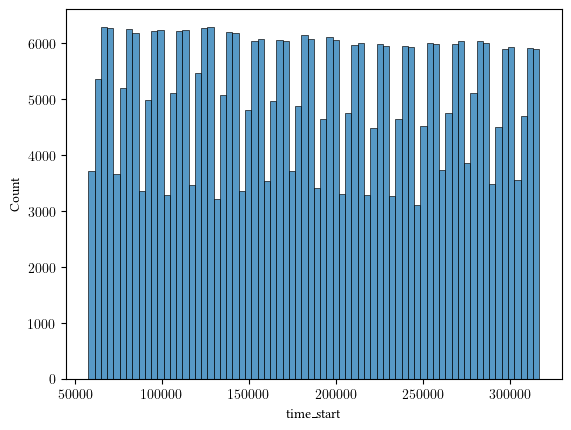

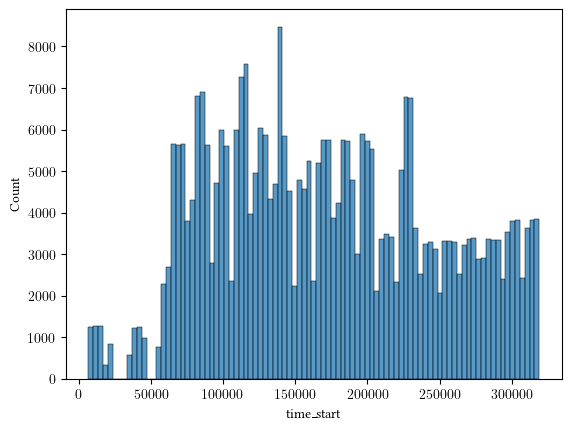

In [269]:
bucket_size = "1s"

dfs = data_invocations("static")
#dfs["time"] = pd.to_datetime(dfs["time_start"], unit="s")
#dfs["time"] = dfs["time"].dt.floor(bucket_size)
#dfs["time"] = (dfs["time"] - dfs["time"].min()).dt.total_seconds().astype(int)
#dfs = dfs.groupby(["time"]).size().reset_index(name="count")

dfd = data_invocations("dynamic")
#dfd["time"] = pd.to_datetime(dfd["time_start"], unit="s")
#dfd["time"] = dfd["time"].dt.floor(bucket_size)
#dfd["time"] = (dfd["time"] - dfd["time"].min()).dt.total_seconds().astype(int)
#dfd = dfd.groupby(["time"]).size().reset_index(name="count")

print(dfs["time_start"].max()-dfs["time_start"].min(), dfd["time_start"].max()-dfd["time_start"].min())

sns.histplot(dfs["time_start"])
plt.show()
sns.histplot(dfd["time_start"])
plt.show()


#fig, ax = plt.subplots(figsize=FIGSIZE_ACM_LARGE)

#print(len(dfs), len(dfd))

#sns.lineplot(x="time", y="count", data=dfd, ax=ax, label="dynamic")
#sns.lineplot(x="time", y="count", data=dfs, ax=ax, label="static")

#plt.show()

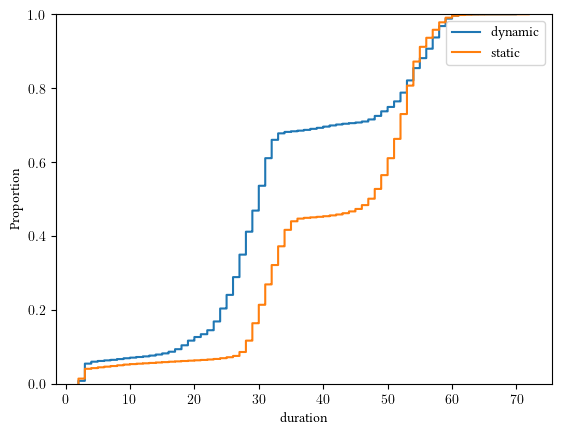

In [201]:
dfd = data_invocations("dynamic")
dfd["duration"] = dfd["time_stop"] - dfd["time_start"]

dfs = data_invocations("static")
dfs["duration"] = dfs["time_stop"] - dfs["time_start"]

sns.ecdfplot(dfd["duration"], label="dynamic")
sns.ecdfplot(dfs["duration"], label="static")
plt.legend()
plt.show()

In [135]:
df = pd.DataFrame(data={
    "time": data_dynamic["time"],
    "W_dynamic": data_dynamic["W"],
    "W_static": data_static["W"],
})
df["savings"] = 1-df["W_dynamic"]/df["W_static"]

In [349]:
a, b = data_static["Wh"].max(), data_dynamic["Wh"].max()
(1-b/a)*100, a, b

(np.float64(7.8511877691722525),
 np.float64(1110.6165233077081),
 np.float64(1023.4199346673672))

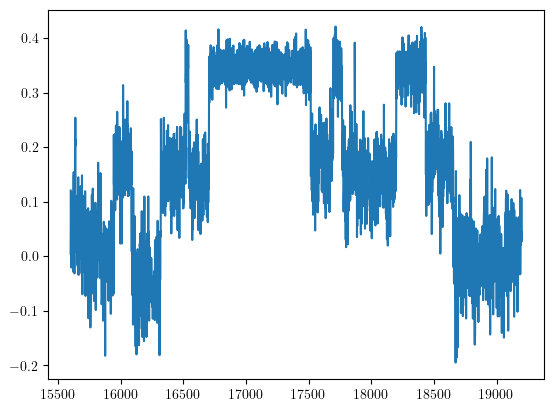

(np.float64(0.16818415211499751), np.float64(0.14653734339582758))

In [138]:
df.head(n=10)

dff = df[df["time"] < (86_400/6/24*32)]
dff = dff[dff["time"] >= (86_400/6/24*26)]
len(dff), (32-26)*600

plt.plot(dff["time"], dff["savings"])
plt.show()

dff["savings"].mean(), dff["savings"].std()

In [109]:
df["savings"].mean()

np.float64(0.08751615165700793)

In [118]:
data_dynamic.head(n=10)

,time,W,J,Wh
0,0,5.93782,0.00000,0.00000
1,1,6.15616,6.04699,0.00168
2,2,6.02508,12.13761,0.00337
3,3,5.22179,17.76105,0.00493
4,4,4.94693,22.84541,0.00635
5,5,5.19156,27.91465,0.00775
6,6,5.10881,33.06484,0.00918
7,7,5.59514,38.41681,0.01067
8,8,5.21613,43.82245,0.01217
9,9,5.12296,48.99199,0.01361


#### Plot Leistung gesamte Cluster mit Clustergröße

In [102]:
# neuer consumption/node count plot aber direkt 2 in 1

dfs = data_consumption(kind="static", melt=False, raw=True)
dfs["nodes_active"] = (dfs["W1"] != 0).astype(np.int64) + (dfs["W2"] != 0) + (dfs["W3"] != 0) + (dfs["W4"] != 0) + (dfs["W5"] != 0)
dfs["nodes_active_scaled"] = dfs["nodes_active"] * 5
dfs["W"] = dfs["W1"] + dfs["W2"] + dfs["W3"] + dfs["W4"] + dfs["W5"]
dfs["time"] = dfs["time"]-dfs["time"].min()

dfd = data_consumption(kind="dynamic", melt=False, raw=True)
dfd["nodes_active"] = (dfd["W1"] != 0).astype(np.int64) + (dfd["W2"] != 0) + (dfd["W3"] != 0) + (dfd["W4"] != 0) + (dfd["W5"] != 0)
dfd["nodes_active_scaled"] = dfd["nodes_active"] * 5
dfd["W"] = dfd["W1"] + dfd["W2"] + dfd["W3"] + dfd["W4"] + dfd["W5"]
dfd["time"] = dfd["time"]-dfd["time"].min()

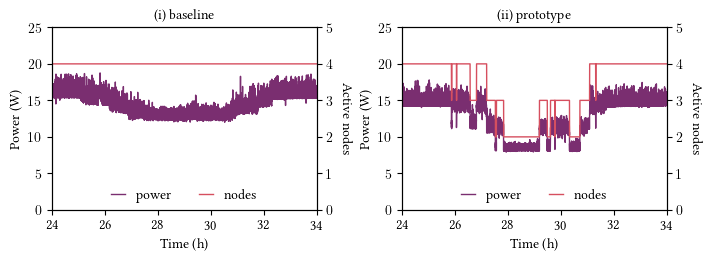

In [30]:
def plot_power_subplots(dfs: pd.DataFrame, dfd: pd.DataFrame, colors: list, filename: str) -> None:

    # fig, (ax1a, ax2a) = plt.subplots(figsize=FIGSIZE_ACM_LARGE, ncols=2, nrows=1, constrained_layout=True)
    fig, (ax1a, ax2a) = plt.subplots(figsize=(7, 2.5), ncols=2, nrows=1, constrained_layout=True)

    sns.lineplot(x="time", y="W", data=dfs, ax=ax1a, linestyle="-", color=colors[0], label="power", linewidth=1)
    sns.lineplot(x="time", y="nodes_active_scaled", data=dfs, ax=ax1a, linestyle="-", color=colors[1], label="nodes", linewidth=1)

    sns.lineplot(x="time", y="W", data=dfd, ax=ax2a, linestyle="-", color=colors[0], label="power", linewidth=1)
    sns.lineplot(x="time", y="nodes_active_scaled", data=dfd, ax=ax2a, linestyle="-", color=colors[1], label="nodes", linewidth=1)

    ax1b = ax1a.twinx()
    ax2b = ax2a.twinx()

    ax1a.set_ylabel("Power (W)")
    ax2a.set_ylabel("Power (W)")
    ax1b.set_ylabel("Active nodes", rotation=270, rotation_mode=None, verticalalignment="center", horizontalalignment="left")
    ax2b.set_ylabel("Active nodes", rotation=270, rotation_mode=None, verticalalignment="center", horizontalalignment="left")

    ax1a.set_xlabel("Time (h)")
    ax2a.set_xlabel("Time (h)")

    ax1a.set_ylim(0, 25)
    ax2a.set_ylim(0, 25)
    ax1b.set_ylim(0, 5)
    ax2b.set_ylim(0, 5)

    ax1a.set_title("(i) baseline")
    ax2a.set_title("(ii) prototype")

    secs = lambda h: int(60*60*h/6)

    ll, ul = 24, 34
    xsteps = 5
    
    ax1a.set_xlim(secs(ll), secs(ul))
    ax2a.set_xlim(secs(ll), secs(ul))
    
    ax1a.set_xticks(
        ticks=range(secs(ll), secs(ul)+1, int((secs(ul)-secs(ll))//(xsteps))), 
        labels=range(ll, ul+1, int((ul-ll)//(xsteps)))
    )
    ax2a.set_xticks(
        ticks=range(secs(ll), secs(ul)+1, int((secs(ul)-secs(ll))//(xsteps))), 
        labels=range(ll, ul+1, int((ul-ll)//(xsteps)))
    )

    ax1a.legend(
        loc="lower center",
        ncols=2,
        frameon=False,
        fancybox=True,
        bbox_to_anchor=(0.5, -0.025),
        handlelength=1 
    )

    ax2a.legend(
        loc="lower center",
        ncols=2,
        frameon=False,
        fancybox=True,
        bbox_to_anchor=(0.5, -0.025),
        handlelength=1
    )

    # fig.subplots_adjust(wspace=0.4)

    fig.savefig(filename)
    plt.show()
    plt.close()


plot_power_subplots(dfs, dfd, colors, "../2025-paper-HaveYouTriedTurningItOff/graphs/subplots_power_draw.pdf")

#### Vergleich Energieverbrauch gesamte Cluster 

In [111]:
data_dynamic = data_consumption("dynamic", False)
data_dynamic["J"] = integrate.cumulative_trapezoid(y=data_dynamic["W"], x=data_dynamic["time"], initial=0)
data_dynamic["Wh"] = data_dynamic["J"]/3_600

data_static = data_consumption("static", False)
data_static["J"] = integrate.cumulative_trapezoid(y=data_static["W"], x=data_static["time"], initial=0)
data_static["Wh"] = data_static["J"]/3_600

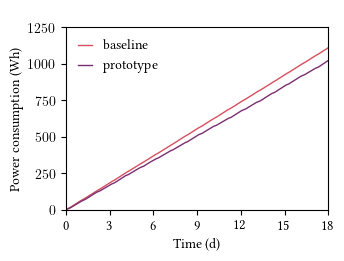

In [100]:
def plot_consumption_cluster_total(data_static: pd.DataFrame, data_dynamic: pd.DataFrame, colors: list) -> None:

    fig, ax = plt.subplots(
        figsize=(3.33, 2.5), 
        constrained_layout=True
    )

    sns.lineplot(x="time", y="Wh", data=data_static, ax=ax, label="baseline", color=colors[1], linewidth=1)
    sns.lineplot(x="time", y="Wh", data=data_dynamic, ax=ax, label="prototype", color=colors[3], linewidth=1)

    ax.set_title(" ", color="white")

    xlim = 86_400 * 3
    ax.set_xlabel("Time (d)")
    ax.set_xlim(0, xlim)
    ax.set_xticks(
        ticks=range(0, xlim+1, xlim//6),
        labels=range(0, 18+1, 3)
    )

    ylim = 1250
    ax.set_ylabel("Power consumption (Wh)")
    ax.set_ylim(0, ylim)

    ax.grid(False)

    ax.legend(
        loc="upper left",
        frameon=False,
        markerfirst=True,
        handlelength=1
    )

    fig.savefig("../2025-paper-HaveYouTriedTurningItOff/graphs/consumption_cluster_total.pdf")
    plt.show()
    plt.close()

plot_consumption_cluster_total(data_static, data_dynamic, colors=colors)

#### Visualisierung Inputdaten

In [33]:
def data_input(n_days: int) -> pd.DataFrame:
    data = []
    for i in range(n_days):
        data.append(pd.read_csv(f"./inputdata/requests_second/day_00{i}.csv"))
    df = pd.concat(data)
    df["total"] = df.loc[:, "0":"199"].astype(float).sum(axis=1)
    return df

df = data_input(7)

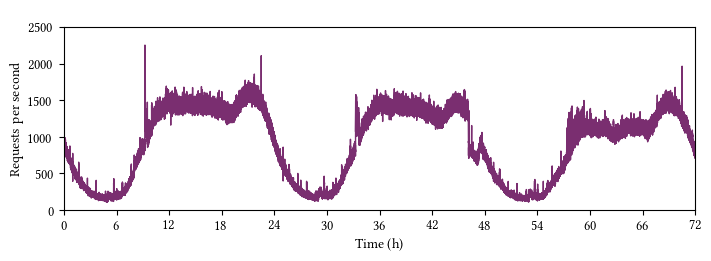

In [98]:
def plot_input_requests_function(df: pd.DataFrame, function_id: int, colors: list, filename: str, smoothing: int = 1) -> None:

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        # figsize=FIGSIZE_ACM_LARGE,
        figsize=(7, 2.5),
        constrained_layout=True
    )

    df = df.copy()
    df = df[df["time"] < 86_400*3]
    df[f"{function_id}"] = df[f"{function_id}"].rolling(window=smoothing, min_periods=1).mean()

    sns.lineplot(x="time", y=f"{function_id}", data=df, ax=ax, linewidth=1, color=colors[3])

    ax.set_title(" ") # for same height as other plots
    ax.set_ylabel("Requests per second")
    ax.set_xlabel("Time (h)")

    ax.set_ylim(0, 2500)
    ax.set_yticks(
        ticks=range(0, 2500+1, 500),
        labels=range(0, 2500+1, 500)
    )

    secs = lambda h: int(60*60*h)

    ll, ul = 0, 72
    xsteps = 12
    
    ax.set_xlim(secs(ll), secs(ul))
    ax.set_xticks(
        ticks=range(
            secs(ll),
            secs(ul)+1,
            int((secs(ul)-secs(ll))//xsteps)
        ),
        labels=range(
            ll,
            ul+1,
            int((ul-ll)//xsteps)
        )
    )

    plt.savefig(filename)
    plt.show()
    plt.close()


colors = sns.color_palette("flare", 4)
plot_input_requests_function(df, "28", colors, "../2025-paper-HaveYouTriedTurningItOff/graphs/input_function28.pdf", 3)

### Latenz-Analyse

Diese Sektion spiegelt die Logik aus `analysis/ematholip.py` wider. Alle `latencies_*.csv`-Dateien unter `Testresults/` werden eingelesen, mit Metadaten aus dem Ordnernamen versehen und anschließend zu aggregierten Kennzahlen für die Bachelorarbeit verdichtet.


In [ ]:
def find_repo_root(marker: str = "Testresults") -> Path:
    current = Path.cwd().resolve()
    for candidate in (current, *current.parents):
        if (candidate / marker).exists():
            return candidate
    raise FileNotFoundError(f"{marker} nicht gefunden. Bitte Arbeitsverzeichnis prüfen.")

REPO_ROOT = find_repo_root()
LATENCY_ROOT = (REPO_ROOT / "Testresults").resolve()
FIGURES_DIR = (REPO_ROOT / "analysis" / "figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Arbeitsverzeichnis: {REPO_ROOT}")
print(f"Latenzdaten: {LATENCY_ROOT}")
print(f"Figure-Output: {FIGURES_DIR}")


In [ ]:
STAGE_RE = re.compile(r"^(?P<label>S(?P<num>\d+))_(?P<mode>[A-Za-z0-9-]+)$")
RUN_RE = re.compile(r"^(?P<date>\d{4}-\d{2}-\d{2})_(?P<time>\d{2}-\d{2}-\d{2})_run-(?P<run_id>[0-9A-Za-z-]+)$")
FILE_RE = re.compile(r"^latencies_(?P<workload>[A-Za-z0-9-]+(?:_[A-Za-z0-9-]+)*)_(?P<date>\d{4}-\d{2}-\d{2})_(?P<time>\d{2}-\d{2}-\d{2})$")

@dataclass(frozen=True)
class FileMetadata:
    csv_path: Path
    stage_label: str
    stage_num: int
    mode: str
    run_folder: str
    run_id: str
    run_started_at: datetime
    workload: str
    file_started_at: datetime


def parse_metadata(csv_path: Path) -> FileMetadata:
    stage_match = STAGE_RE.match(csv_path.parents[2].name)
    if not stage_match:
        raise ValueError(f"Stage konnte nicht aus {csv_path} gelesen werden")

    run_match = RUN_RE.match(csv_path.parents[1].name)
    if not run_match:
        raise ValueError(f"Run konnte nicht aus {csv_path} gelesen werden")

    file_match = FILE_RE.match(csv_path.stem)
    if not file_match:
        raise ValueError(f"Workload konnte nicht aus {csv_path.name} gelesen werden")

    run_started = datetime.fromisoformat(f"{run_match['date']}T{run_match['time'].replace('-', ':')}")
    file_started = datetime.fromisoformat(f"{file_match['date']}T{file_match['time'].replace('-', ':')}")

    return FileMetadata(
        csv_path=csv_path,
        stage_label=stage_match["label"],
        stage_num=int(stage_match["num"]),
        mode=stage_match["mode"],
        run_folder=csv_path.parents[1].name,
        run_id=run_match["run_id"],
        run_started_at=run_started,
        workload=file_match["workload"],
        file_started_at=file_started,
    )


def series_stats(series: pd.Series, prefix: str) -> dict:
    clean = series.dropna()
    if clean.empty:
        return {f"{prefix}_{name}": None for name in ("count", "mean", "p50", "p95", "p99", "min", "max")}
    return {
        f"{prefix}_count": float(clean.count()),
        f"{prefix}_mean": float(clean.mean()),
        f"{prefix}_p50": float(clean.quantile(0.5)),
        f"{prefix}_p95": float(clean.quantile(0.95)),
        f"{prefix}_p99": float(clean.quantile(0.99)),
        f"{prefix}_min": float(clean.min()),
        f"{prefix}_max": float(clean.max()),
    }


def load_latency_paths(root: Path) -> List[Path]:
    return sorted(root.rglob("latencies_*.csv"))


def gather_records(csv_paths: Iterable[Path]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    records = []
    sample_frames = []
    for csv_path in csv_paths:
        meta = parse_metadata(csv_path)
        df = pd.read_csv(csv_path)
        if "ts_iso" in df:
            df["ts_iso"] = pd.to_datetime(df["ts_iso"], errors="coerce")
        else:
            df["ts_iso"] = pd.NaT
        total_count = len(df)
        success = df[df["http_status"] == 200]

        client_series = success["client_total_ms"] if "client_total_ms" in success else pd.Series(dtype=float)
        server_series = success["server_latency_ms"] if "server_latency_ms" in success else pd.Series(dtype=float)

        record = {
            "csv_path": str(csv_path),
            "stage_label": meta.stage_label,
            "stage_num": meta.stage_num,
            "mode": meta.mode,
            "workload": meta.workload,
            "run_folder": meta.run_folder,
            "run_id": meta.run_id,
            "run_started_at": meta.run_started_at.isoformat(),
            "file_started_at": meta.file_started_at.isoformat(),
            "run_date": meta.run_started_at.date().isoformat(),
            "total_samples": total_count,
            "successful_samples": int(success.shape[0]),
            "error_rate": float(1 - (success.shape[0] / total_count)) if total_count else None,
            "ts_first": success["ts_iso"].min().isoformat() if not success["ts_iso"].isna().all() else None,
            "ts_last": success["ts_iso"].max().isoformat() if not success["ts_iso"].isna().all() else None,
        }
        record.update(series_stats(client_series, "client"))
        record.update(series_stats(server_series, "server"))
        records.append(record)

        subset = success[[col for col in ["client_total_ms", "server_latency_ms"] if col in success]].copy()
        subset["stage_num"] = meta.stage_num
        subset["stage_label"] = meta.stage_label
        subset["mode"] = meta.mode
        subset["workload"] = meta.workload
        subset["run_date"] = meta.run_started_at.date().isoformat()
        sample_frames.append(subset)

    run_summary = pd.DataFrame(records)
    samples = pd.concat(sample_frames, ignore_index=True) if sample_frames else pd.DataFrame()
    return run_summary, samples


def aggregate_categories(run_summary: pd.DataFrame) -> pd.DataFrame:
    if run_summary.empty:
        return pd.DataFrame()
    key_cols = ["run_date", "stage_num", "stage_label", "mode", "workload"]
    metric_cols = [col for col in run_summary.columns if col.startswith(("client_", "server_")) and col.endswith(("mean", "p50", "p95", "p99"))]
    agg_map = {col: ["mean", "std"] for col in metric_cols}
    agg_map.update({"successful_samples": ["mean"], "error_rate": ["mean"]})
    grouped = run_summary.groupby(key_cols).agg(agg_map)
    grouped.columns = [f"{col}_{stat}" for col, stat in grouped.columns]
    return grouped.reset_index()


def compute_phase_deltas(category_summary: pd.DataFrame) -> pd.DataFrame:
    if category_summary.empty:
        return pd.DataFrame()
    metric_cols = [col for col in category_summary.columns if col.startswith(("client_", "server_"))]
    frames = []
    for (_, mode, workload), group in category_summary.groupby(["run_date", "mode", "workload"]):
        sorted_group = group.sort_values("stage_num").copy()
        for col in metric_cols:
            sorted_group[f"{col}_delta_prev"] = sorted_group[col].diff()
            sorted_group[f"{col}_delta_from_s0"] = sorted_group[col] - sorted_group[col].iloc[0]
        frames.append(sorted_group)
    return pd.concat(frames, ignore_index=True)


#### Datengrundlage aus `Testresults`


In [ ]:
latency_paths = load_latency_paths(LATENCY_ROOT)
print(f"Gefundene CSV-Dateien: {len(latency_paths)}")

run_summary, samples = gather_records(latency_paths)
category_summary = aggregate_categories(run_summary)
phase_deltas = compute_phase_deltas(category_summary)


In [ ]:
from IPython.display import display

print("Run-Summary (erste Zeilen):")
display(run_summary.head())

print("Kategorie-Summary (erste Zeilen):")
display(category_summary.head())

print("Phasen-Deltas (erste Zeilen):")
display(phase_deltas.head())


#### Visualisierung von Latenzen


In [ ]:
def _build_palette(n: int) -> list:
    base = sns.color_palette("flare", max(3, n + 2))
    return base[:n]


def plot_stage_metric(df: pd.DataFrame, workload: str, metric: str, ylabel: str, filename: Optional[str] = None) -> None:
    subset = df[df["workload"] == workload].sort_values("stage_num")
    if subset.empty:
        raise ValueError(f"Keine Daten für Workload {workload} gefunden")

    fig, ax = plt.subplots(figsize=FIGSIZE_ACM_LARGE, constrained_layout=True)
    palette = _build_palette(subset["mode"].nunique())
    for (mode, group), color in zip(subset.groupby("mode"), palette):
        sns.lineplot(data=group, x="stage_num", y=metric, marker="o", ax=ax, label=mode, color=color, linewidth=1)

    ax.set_xlabel("Stage")
    ax.set_ylabel(ylabel)
    ax.set_xticks(sorted(subset["stage_num"].unique()))
    ax.grid(False)
    ax.set_title(f"{workload}: {metric}")
    ax.legend(frameon=False)

    if filename:
        out_path = FIGURES_DIR / filename
        fig.savefig(out_path)
        print(f"Gespeichert: {out_path}")

    plt.show()
    plt.close()


def plot_latency_boxplot(samples: pd.DataFrame, workload: str, metric: str, ylabel: str, filename: Optional[str] = None) -> None:
    subset = samples[(samples["workload"] == workload) & samples[metric].notna()]
    if subset.empty:
        raise ValueError(f"Keine Samples für Workload {workload} vorhanden")

    fig, ax = plt.subplots(figsize=FIGSIZE_ACM_LARGE, constrained_layout=True)
    palette = _build_palette(subset["mode"].nunique())

    sns.boxplot(
        data=subset,
        x="stage_num",
        y=metric,
        hue="mode",
        palette=palette,
        ax=ax,
    )
    ax.set_xlabel("Stage")
    ax.set_ylabel(ylabel)
    ax.set_title(f"Verteilung {workload} – {metric}")
    ax.legend(frameon=False)

    if filename:
        out_path = FIGURES_DIR / filename
        fig.savefig(out_path)
        print(f"Gespeichert: {out_path}")

    plt.show()
    plt.close()


In [ ]:
available_workloads = sorted(category_summary["workload"].unique()) if not category_summary.empty else []
print(f"Workloads: {available_workloads}")

if available_workloads:
    focus_workload = available_workloads[0]
    plot_stage_metric(
        category_summary,
        workload=focus_workload,
        metric="client_p95_mean_mean",
        ylabel="Client p95 (ms)",
        filename=f"stage_metric_{focus_workload}.pdf",
    )
    plot_latency_boxplot(
        samples,
        workload=focus_workload,
        metric="client_total_ms",
        ylabel="Client-Latenz (ms)",
        filename=f"boxplot_client_{focus_workload}.pdf",
    )
else:
    print("Keine Workloads gefunden – prüfen, ob Testresults korrekt eingebunden ist.")
